# DeepLDA: Alanine dipeptide and aldol reaction

Reference paper: _Bonati, Rizzi and Parrinello, [JCPL](https://pubs.acs.org/doi/10.1021/acs.jpclett.0c00535) (2020)_ [[arXiv]](https://arxiv.org/abs/2002.06562).

Prerequisite: DeepLDA tutorial.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/luigibonati/mlcolvar/blob/main/docs/notebooks/examples/ex_DeepLDA.ipynb)

## Setup

In [1]:
# Colab setup
import os

if os.getenv("COLAB_RELEASE_TAG"):
    import subprocess
    subprocess.run('wget https://raw.githubusercontent.com/luigibonati/mlcolvar/main/colab_setup.sh', shell=True)
    cmd = subprocess.run('bash colab_setup.sh EXAMPLE', shell=True, stdout=subprocess.PIPE)
    print(cmd.stdout.decode('utf-8'))

# IMPORT PACKAGES
import torch
import lightning
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from mlcolvar.data import DictDataset, DictModule

# Set seed for reproducibility
torch.manual_seed(41)

## Alanine dipeptide

We first train a DeepLDA CV on the alanine dipeptide data, which is one of the examples of the [DeepLDA paper](https://pubs.acs.org/doi/10.1021/acs.jpclett.0c00535). This is a small molecule often used as a benchmark for enhanced sampling, as it has two metastable states which are well described by the Ramachandran angles $\phi$ and $\psi$. To build a general mode, we will not use this information and just use as input features the 45 distances between heavy atoms.

<center><img src="https://github.com/luigibonati/mlcolvar/blob/main/docs/notebooks/examples/images/alanine.png?raw=1" width="500" /></center>

### Load data

We use the alanine dipeptide simulation data from the [PLUMED-MASTERCLASS](https://github.com/luigibonati/masterclass-plumed/) repository.

In [2]:
from mlcolvar.utils.io import create_dataset_from_files
from mlcolvar.data import DictModule

filenames = [ "https://raw.githubusercontent.com/luigibonati/masterclass-plumed/main/1_DeepLDA/0_unbiased-sA/COLVAR",
              "https://raw.githubusercontent.com/luigibonati/masterclass-plumed/main/1_DeepLDA/0_unbiased-sB/COLVAR" ]

n_states = len(filenames)

# load dataset
dataset, df = create_dataset_from_files(filenames,
                                        filter_args={'regex':'d_' }, # select distances between heavy atoms
                                        create_labels=True,
                                        return_dataframe=True,
                                        )

datamodule = DictModule(dataset,lengths=[0.8,0.2])

Class 0 dataframe shape:  (5001, 53)
Class 1 dataframe shape:  (5001, 53)

 - Loaded dataframe (10002, 53): ['time', 'phi', 'psi', 'theta', 'xi', 'ene', 'd_2_5', 'd_2_6', 'd_2_7', 'd_2_9', 'd_2_11', 'd_2_15', 'd_2_16', 'd_2_17', 'd_2_19', 'd_5_6', 'd_5_7', 'd_5_9', 'd_5_11', 'd_5_15', 'd_5_16', 'd_5_17', 'd_5_19', 'd_6_7', 'd_6_9', 'd_6_11', 'd_6_15', 'd_6_16', 'd_6_17', 'd_6_19', 'd_7_9', 'd_7_11', 'd_7_15', 'd_7_16', 'd_7_17', 'd_7_19', 'd_9_11', 'd_9_15', 'd_9_16', 'd_9_17', 'd_9_19', 'd_11_15', 'd_11_16', 'd_11_17', 'd_11_19', 'd_15_16', 'd_15_17', 'd_15_19', 'd_16_17', 'd_16_19', 'd_17_19', 'walker', 'labels']
 - Descriptors (10002, 45): ['d_2_5', 'd_2_6', 'd_2_7', 'd_2_9', 'd_2_11', 'd_2_15', 'd_2_16', 'd_2_17', 'd_2_19', 'd_5_6', 'd_5_7', 'd_5_9', 'd_5_11', 'd_5_15', 'd_5_16', 'd_5_17', 'd_5_19', 'd_6_7', 'd_6_9', 'd_6_11', 'd_6_15', 'd_6_16', 'd_6_17', 'd_6_19', 'd_7_9', 'd_7_11', 'd_7_15', 'd_7_16', 'd_7_17', 'd_7_19', 'd_9_11', 'd_9_15', 'd_9_16', 'd_9_17', 'd_9_19', 'd_11_15

In [4]:
class CL_dataset(Dataset):
    def __init__(
        self,
        data_list,
        data_augmented_list,
        data_augmented_hard_list,
        temperature_list,
    ):
        super(CL_dataset, self).__init__()
        self.x = data_list
        self.x_augmented = data_augmented_list
        self.x_augmented_hard = data_augmented_hard_list
        self.temperature = temperature_list
        
    def __getitem__(self, index):
	    return self.x[index], self.x_augmented[index], self.x_augmented_hard[index], self.temperature[index]
 
    def __len__(self):
	    return self.x.shape[0]
 

In [5]:
custom_dataset = torch.load("../data/dataset/alanine/300.0/v3/cl-distance.pt")
custom_label = torch.tensor([0, 1], dtype=torch.float32).repeat(200000)
custom_dataset.x.shape
custom_label.shape

torch.Size([400000])

In [6]:
new_dataset = DictDataset({
	"data": custom_dataset.x,
	"labels": custom_label
})
# datamodule = DictModule(new_dataset,lengths=[0.8,0.2])

### Train DeepLDA

Define CV

In [7]:
from mlcolvar.cvs import DeepLDA

# n_input = dataset['data'].shape[-1]
n_states=2
n_input = 45
nodes = [n_input,30,30,2]
# MODEL
model = DeepLDA(nodes, n_states=n_states)

model

DeepLDA(
  (loss_fn): ReduceEigenvaluesLoss()
  (norm_in): Normalization(in_features=45, out_features=45, mode=mean_std)
  (nn): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=45, out_features=30, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=30, out_features=30, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=30, out_features=2, bias=True)
    )
  )
  (lda): LDA(in_features=2, out_features=1)
)

Define trainer and fit

In [ ]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from mlcolvar.utils.trainer import MetricsCallback

# define callbacks
metrics = MetricsCallback()
early_stopping = EarlyStopping(monitor="valid_loss", min_delta=0.1, patience=50)

# define trainer
trainer = lightning.Trainer(callbacks=[metrics, early_stopping],
                     max_epochs=None, logger=None, enable_checkpointing=False)

# fit
trainer.fit( model, datamodule )

#### Analysis of the CV

In [11]:
# evaluate cv on training set and append to dataframe
X = dataset[:]['data']
model.eval()
with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()

n_components = n_states-1

for i in range(n_components):
    df[f'CV{i}'] = s[:,i]

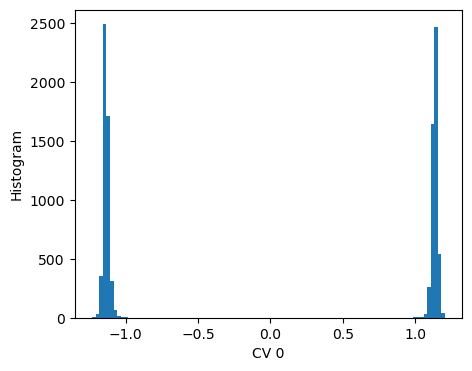

In [12]:
fig,axs = plt.subplots(1,n_components,figsize=(5*n_components,4))
if n_components == 1:
    axs = [axs]

for i,ax in enumerate(axs):
    ax.hist(s[:,i],bins=100)
    ax.set_xlabel(f'CV {i}')
    ax.set_ylabel('Histogram')

In [17]:
print(df['CV0'].min())
print(df['CV0'].max())

-1.2312578
1.204186


In [13]:
n_components = 1

fig,axs = plt.subplots(1,n_components,figsize=(5*n_components,4))
if n_components == 1:
    axs = [axs]

for i,ax in enumerate(axs):
    df.plot.hexbin('phi','psi',C=f'CV{i}',cmap='fessa',ax=ax)
    ax.set_title(f'CV {i} in phi/psi space')